In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

## 1. 법정동 코드 가공

In [3]:
locCode = pd.read_excel('./data/법정동코드.xlsx')

## 2. 실거래가 데이터 가공

In [4]:
apt = pd.read_csv('./data/2019년 서울 아파트 실거래가.csv', encoding="cp949")
apt.head()

,건축년도,거래년도,거래월,거래일자,법정동,거래금액,아파트이름,전용면적,지역코드,층,지번
0,2008,2019,1,7,사직동,"105,000",광화문풍림스페이스본(101동~105동),97.61,11110,10,9
1,2008,2019,1,11,사직동,"162,000",광화문풍림스페이스본(106동),163.33,11110,11,9-1
2,2008,2019,1,19,사직동,"119,000",광화문풍림스페이스본(101동~105동),131.44,11110,13,9
3,2008,2019,1,30,사직동,"119,000",광화문풍림스페이스본(101동~105동),147.31,11110,1,9
4,2004,2019,1,25,내수동,"160,000",경희궁의아침4단지,150.48,11110,14,73


## apt DF에서 지역코드가 5자리만 나옴
- 서울시 XX구  까지만 매칭가능
- 글새ㅓ locCode다시 매칭

In [5]:
apt.head()

,건축년도,거래년도,거래월,거래일자,법정동,거래금액,아파트이름,전용면적,지역코드,층,지번
0,2008,2019,1,7,사직동,"105,000",광화문풍림스페이스본(101동~105동),97.61,11110,10,9
1,2008,2019,1,11,사직동,"162,000",광화문풍림스페이스본(106동),163.33,11110,11,9-1
2,2008,2019,1,19,사직동,"119,000",광화문풍림스페이스본(101동~105동),131.44,11110,13,9
3,2008,2019,1,30,사직동,"119,000",광화문풍림스페이스본(101동~105동),147.31,11110,1,9
4,2004,2019,1,25,내수동,"160,000",경희궁의아침4단지,150.48,11110,14,73


In [6]:
# 거래금액 컬럼의 콤마(,) 제거 후 데이터 타입 변경..int64로
apt['거래금액'] = apt['거래금액'].apply(str)

In [7]:
### 전용면적을 범주화 하기 위해 전용면적(평) 컬럼을 정수형으로 바꾼 새로운 컬럼을 생성합니다.
### 컬럼명 전용면적2(평)
apt['전용면적(평)2'] = round(apt['전용면적']/3.306)

In [8]:
# 전용면적을 범주화 합니다.
# 컬럼명은 전용면적(평)3
apt['전용면적(평)3'] =  apt['전용면적(평)2'].apply(lambda x:f'({int((x//5)*5)},{int((x//5+1)*5)}]')
apt.head(2)

,건축년도,거래년도,거래월,거래일자,법정동,거래금액,아파트이름,전용면적,지역코드,층,지번,전용면적(평)2,전용면적(평)3
0,2008,2019,1,7,사직동,"105,000",광화문풍림스페이스본(101동~105동),97.61,11110,10,9,30.0,"(30,35]"
1,2008,2019,1,11,사직동,"162,000",광화문풍림스페이스본(106동),163.33,11110,11,9-1,49.0,"(45,50]"


In [9]:
# 범주화된 전용면적의 고유값을 확인합니다.
apt['전용면적(평)3'].unique()

array(['(30,35]', '(45,50]', '(40,45]', '(5,10]', '(15,20]', '(25,30]',
       '(20,25]', '(0,5]', '(10,15]', '(35,40]', '(50,55]', '(70,75]',
       '(65,70]', '(60,65]', '(55,60]', '(80,85]', '(75,80]'],
      dtype=object)

## 3. 데이타 프레임 병합

In [10]:
#서울시빼고는 다 지우기
locCode = locCode[locCode['시도명']=='서울특별시']
#필요한 정보만 남기기
locCode= locCode[['법정동코드','시도명','시군구명','읍면동명','동리명']]
#apt와 매치해서 구를 구하기 위하여 5자리까지남기고 다빼기
locCode['법정동코드'] = locCode['법정동코드'].apply(lambda x: int(str(x)[:5]))
### 법정동DF와 apt 를 합치는 중
apt['시군구명'] = apt['지역코드'].apply(lambda x: locCode[locCode['법정동코드']==x]['시군구명'].values[0])

In [11]:
apt.to_csv("processedData.csv")

In [12]:
apt = pd.read_csv("processedData.csv").drop('Unnamed: 0', axis=1)

## 4. 데이타 분석 + 시각화


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

### 4.1. 지역별 평균 (구/동) 평단가

In [14]:
#지역별 평균 (구/동)평단가
# 거래금액을 int로 바꾸
apt['거래금액'] = apt['거래금액'].apply(lambda x: int(x.replace(',','')))
apt['평단가']= round(apt['거래금액']/ apt['전용면적(평)2'])

In [15]:
apt['시군구명'].nunique()

25

In [17]:
구별평단가평균및갯수 = apt.groupby(['시군구명'])[['평단가']].mean().round()
구별평단가평균및갯수['거래량'] = apt.groupby(['시군구명']).count()['아파트이름']
구별평단가평균및갯수.sort_values('평단가',inplace=True)

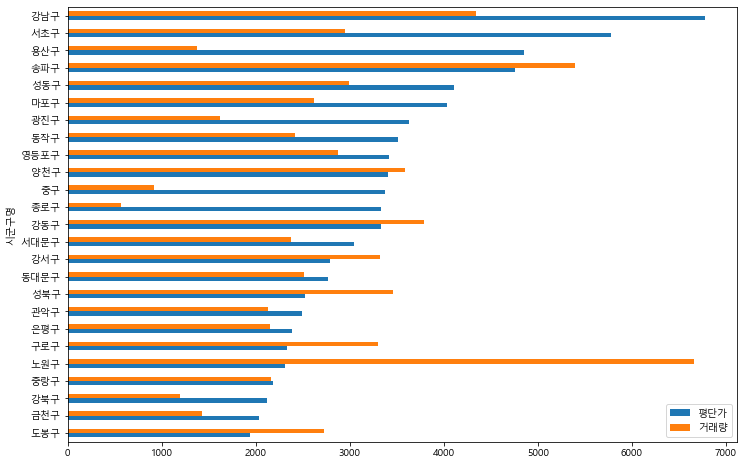

In [19]:
구별평단가평균및갯수.plot(kind='barh',figsize=(12,8))
plt.show()

### 4.2. 시기별 평단가
- 각 구당 월 평단가가 제일 높은 날과, 적은날을 확인하여 비수기와 성수기의 거래가 차이를 가정 할 수 있다.

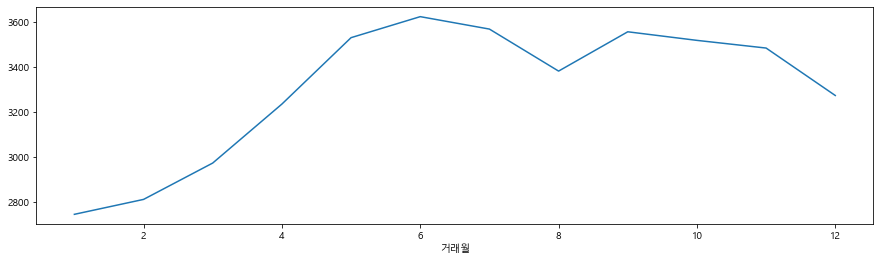

In [27]:
plt.figure(figsize=(15,4))
월별평단가['평단가'].plot()

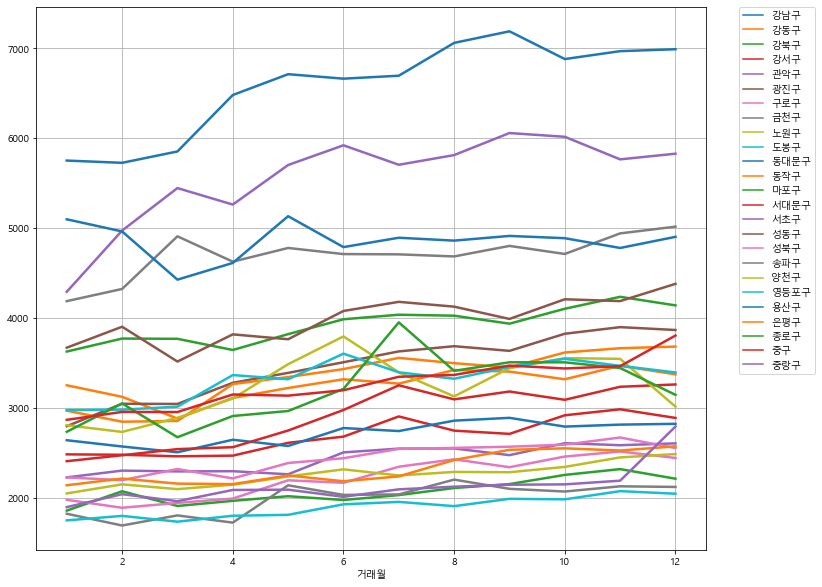

In [54]:
disMonth = apt.pivot_table(values='평단가',index='거래월',columns='시군구명',aggfunc='mean')
plt.figure(figsize=(12, 10))
sns.lineplot(data=disMonth, palette="tab10", linewidth=2.5,dashes=False)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #레이블 위치변경용
plt.show()

### 4.3.층수별 평단가

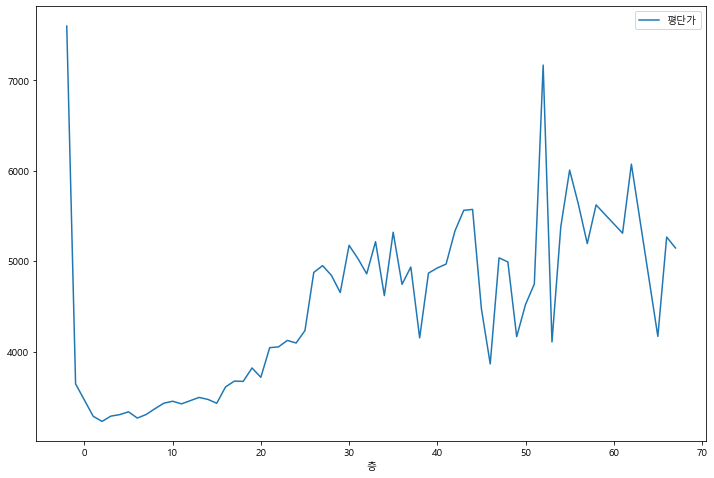

In [33]:
apt.pivot_table(values='평단가',index='층',aggfunc='mean').plot(figsize=(12,8))
plt.show()

In [37]:
구층평단가 = apt.groupby(['시군구명','층'])[['평단가']].mean().reset_index().set_index('층')

In [39]:
구층평단가.head(3)

,시군구명,평단가
층,,
-1,강남구,3141.500000
1,강남구,7037.076305
2,강남구,7141.069930


<Figure size 1152x864 with 0 Axes>

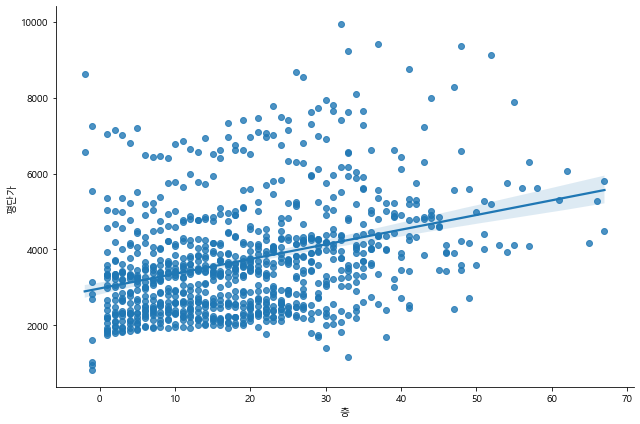

In [47]:
plt.figure(figsize=(16,12))
sns.lmplot(x="층", y="평단가", data=구층평단가.reset_index(),height=6, aspect=1.5)
plt.show()

### 4.4. 건축년도별 평단가

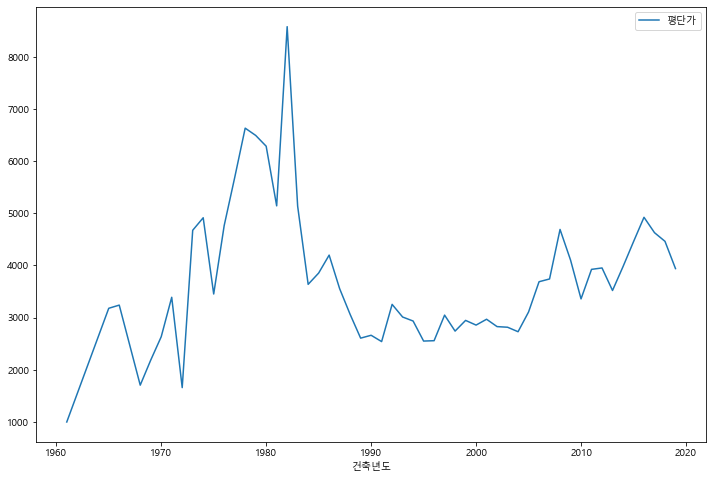

In [50]:
#건축년도 평단가
apt.groupby(['건축년도'])[['평단가']].mean().round().plot(figsize=(12,8))

### 4.5. 아파트 브랜드별 평단가

In [55]:
apt['아파트이름'].apply(lambda x:x.split('(')[0]).value_counts()

현대         1000
두산          538
한신          500
신동아         459
삼성래미안       441
           ... 
구암            1
장인이즈빌         1
현대쉴러하우스       1
라메즈아파트        1
효림다온          1
Name: 아파트이름, Length: 4591, dtype: int64

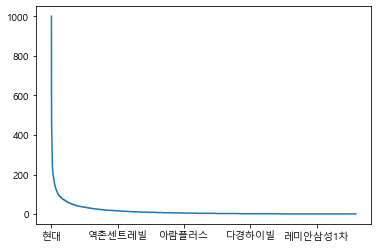

In [56]:
apt['아파트이름'].apply(lambda x:x.split('(')[0]).value_counts().plot()

In [57]:
apt[apt['아파트이름'].str.contains('현대')]['아파트이름'].unique()

array(['현대뜨레비앙', '청운현대', '현대', '현대한강', '현대하이페리온', '현대맨숀', '현대안성타워',
       '현대플래티앙1(1-67)', '무학현대', '서울숲한양현대', '금호현대', '현대그린', '현대I-PARK',
       '뚝섬현대', '강변현대', '구의현대6단지', '현대3', '현대파크빌', '자양동현대', '자양현대6',
       '현대프라임', '구의현대2단지', '강변현대하이엘', '광장11현대홈타운', '구의역현대하이엘',
       '자양9차현대홈타운', '자양7차현대홈타운', '현대강변', '화양현대', '현대8(801동,802동)', '현대5',
       '광나루현대', '자양2현대', '구의현대7단지현대홈타운', '현대8(803동)', '현대홈타운12차', '자양현대5',
       '현대빌라트', '현대13차폴라트리움', '광장현대9단지', '자양10차현대홈타운', '한강현대', '현대리버빌',
       '자양8차현대홈타운', '현대썬앤빌청계', '장안현대홈타운(336)', '장안현대', '신현대', '휘경베스트빌현대',
       '현대홈타운2차', '현대홈타운3차', '현대리노빌', '현대썬앤빌601', '현대코아', '현대휴온', '현대휴앤미',
       '현대아이파크', '현대휴앤미(102동)', '구현대', '돈암현대아파트', '삼선현대힐스테이트', '길음현대',
       '동소문현대', '수유현대', '현대(190-2)', '현대성우', '오동공원현대', '현대(148-494)',
       '현대1', '대상타운현대아파트', '현대조합', '창동현대타운', '창동3차현대', '창동현대4차', '현대2',
       '창동2차현대', '현대성우아파트', '현대아파트', '하계2현대', '상계현대1차', '상계현대3차', '불암현대',
       '현대(3차)', '현대(6차)', '현대1(4차)', '중계현대2', '노원현대', '현대2차', '수락현대',
  

### 4.6. 평수별 거래량

In [58]:
# 총거래수 68864 / 평수종류수 80
# 종류당 860개정도 있음...
apt.shape[0] / apt['전용면적(평)2'].nunique()

860.8

In [59]:
apt.head(2)

,건축년도,거래년도,거래월,거래일자,법정동,거래금액,아파트이름,전용면적,지역코드,층,지번,전용면적(평)2,전용면적(평)3,시군구명,평단가
0,2008,2019,1,7,사직동,105000,광화문풍림스페이스본(101동~105동),97.61,11110,10,9,30.0,"(30,35]",종로구,3500.0
1,2008,2019,1,11,사직동,162000,광화문풍림스페이스본(106동),163.33,11110,11,9-1,49.0,"(45,50]",종로구,3306.0


In [61]:
apt.groupby(['전용면적(평)2'])[['평단가']].mean().round().head()

,평단가
전용면적(평)2,
3.0,4750.0
4.0,3410.0
5.0,3148.0
6.0,3180.0
7.0,3676.0


In [63]:
apt.groupby(['전용면적(평)3'])[['평단가']].mean().round().head(3)

,평단가
전용면적(평)3,
"(0,5]",3424.0
"(10,15]",3112.0
"(15,20]",3531.0


In [70]:
히트맵 =  apt.pivot_table(values='거래일자',index=['시군구명'],columns='전용면적(평)3',aggfunc='count').fillna(0).astype(int)

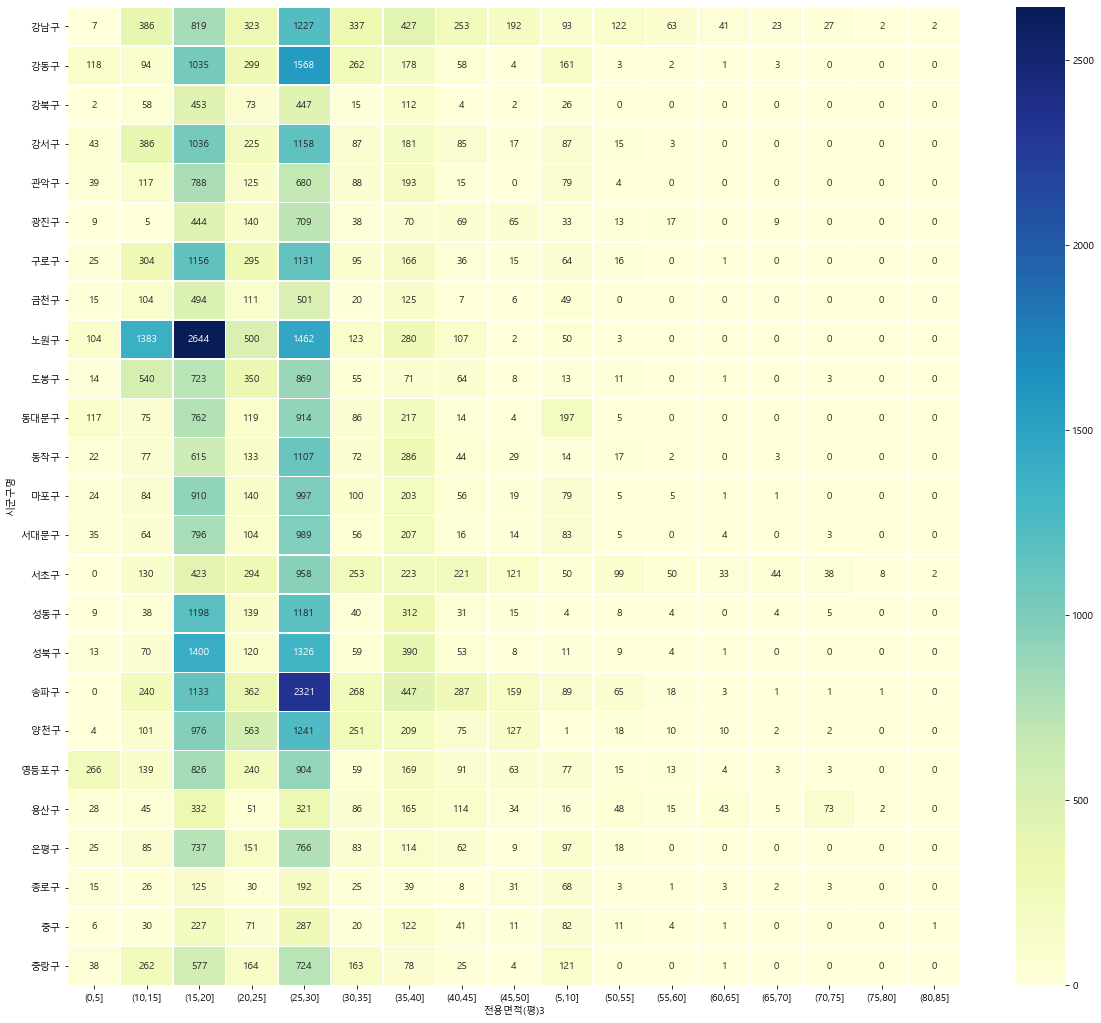

In [71]:
plt.figure(figsize=(20,18))
sns.heatmap(히트맵, annot=True, fmt="d", linewidths=.5,cmap="YlGnBu")

### 4.7. 지역별거래량

In [73]:
지역별거래량 = apt.groupby('시군구명').count()[['평단가']]
지역별거래량.head(3)

,평단가
시군구명,
강남구,4344
강동구,3786
강북구,1192


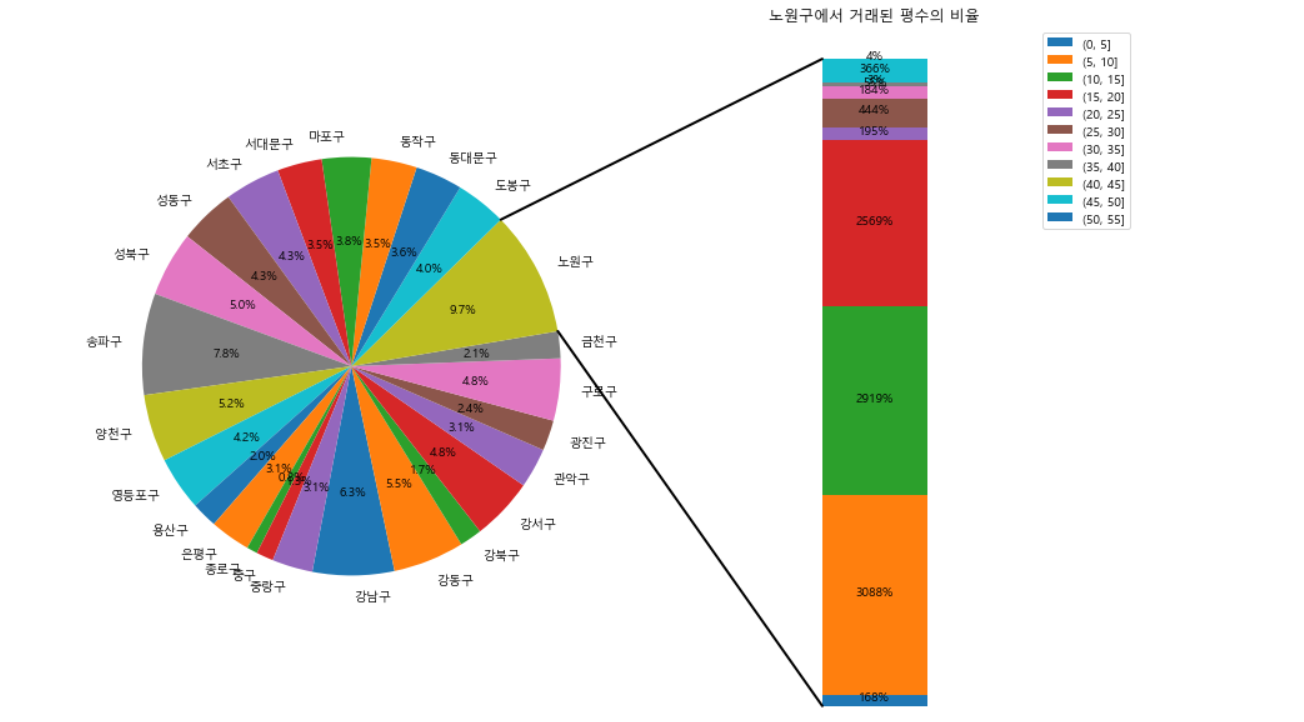

In [114]:
from matplotlib.patches import ConnectionPatch
# make figure and assign axis objects
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)


# pie chart parameters
# rotate so that first wedge is split by the x-axis
angle = -180 * ratio[1]
ax1.pie(disp.loc[:,'전용면적(평)'], autopct='%1.1f%%', startangle=angle,
        labels=disp.index)

xpos = 0
width = .2
bottom = 0

for j in range(len(nop.loc[:,'전용면적(평)'])):
    height = nop.loc[:,'전용면적(평)'][j]
    ax2.bar(xpos, height, width, bottom=bottom)
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('노원구에서 거래된 평수의 비율')
ax2.legend(sell.index)
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

theta1, theta2 = ax1.patches[8].theta1, ax1.patches[8].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)
Q
plt.show()

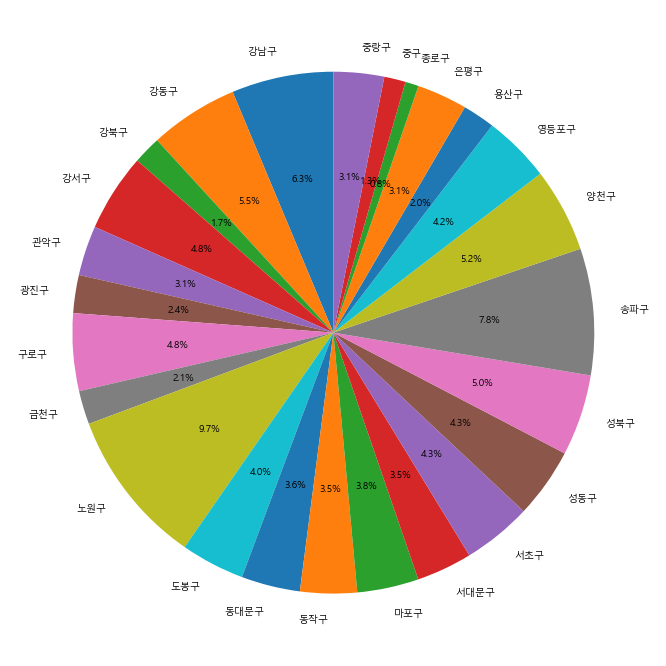

In [80]:
plt.figure(figsize=(12,12))
labels = 지역별거래량.index.values
sizes = 지역별거래량['평단가']
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.rcParams['font.family'] = 'Malgun Gothic'
# create a color palette
palette = plt.get_cmap('Set1')
plt.pie(sizes, labels=labels,explode=explode,autopct='%1.1f%%', startangle=90)

plt.show()

### 4.8. 건축년도별 거래량
- 수요자들의 선호도

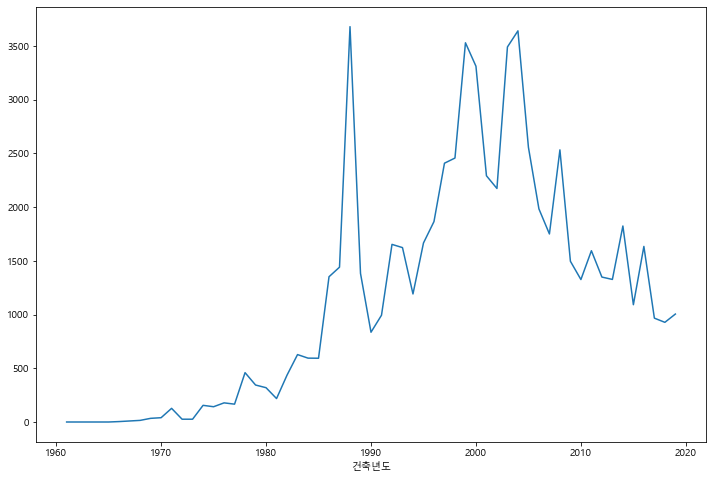

In [82]:
거래량 ='평단가'
apt.groupby(['건축년도']).count()[거래량].plot(figsize=(12,8))

### 4.9. 월별 거래량

In [86]:
월_구별거래량 = apt.groupby(['거래월','시군구명']).count()[['평단가']]
월_구별거래량 = 월_구별거래량.reset_index()
월_구별거래량.head(3)

,거래월,시군구명,평단가
0,1,강남구,76
1,1,강동구,99
2,1,강북구,29


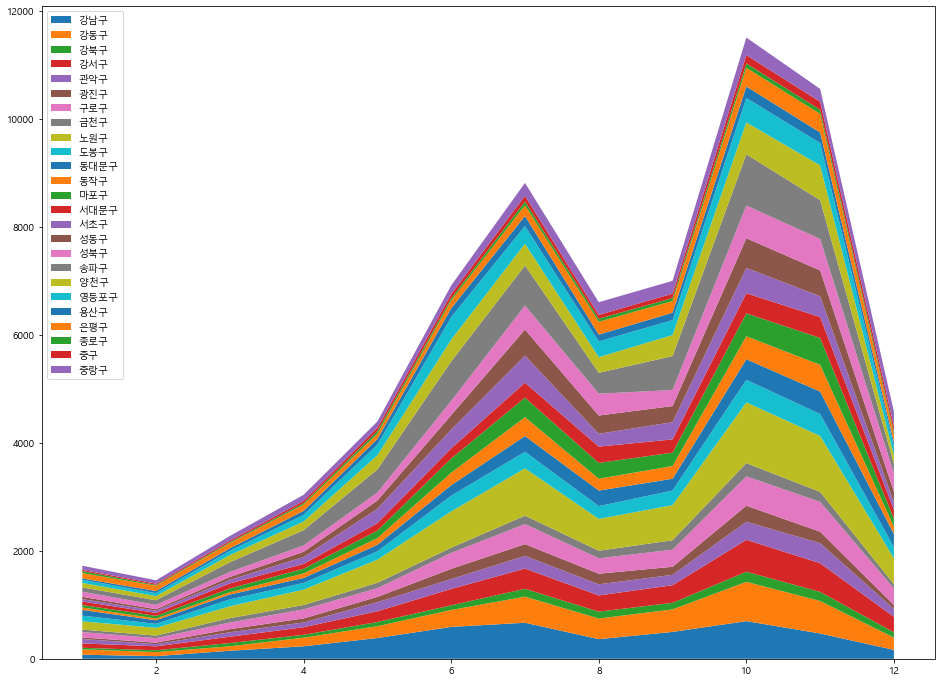

In [84]:
plt.figure(figsize=(16,12))
십이개월 = range(1,13)
구월별리스트 = []
구리스트 = list(월_구별거래량['시군구명'].unique())
for 구 in 구리스트:
    curList = [0,0,0,0,0,0,0,0,0,0,0,0]
    curDF = 월_구별거래량[월_구별거래량['시군구명']==구]
    for 월 in range(1,13):
        if 월 in (curDF['거래월'].values):
            curList[월-1] = curDF[curDF['거래월']==월]['평단가'].values[0]
        else:
            curList[월-1] = 0
    구월별리스트.append(curList)
labels = 구리스트
plt.stackplot(십이개월,구월별리스트,labels=labels)
plt.legend(loc='upper left')
plt.show()